In [3]:
#only use WORKFLOW CLASSIFICATION EXPORT of the desired workflow version, not just classification export

#in the final coordinate files for a galaxy, include ALL classified points, even if there are
#somehow repeats -- I'd like to be able to get a value for spread of points eventually to
#pinpoint galaxies that might need expert eyes on them -- a galaxy with a high spread of
#determined "center" points likely needs some extra help figuring them out


#how to format final file? Should it also be a {,},{,}... file? I'd rather have it all in one csv output 
#file rather than multiple
#if the output could be a table format with column 1 = galaxy, c2 = image is good or bad (most of
#the classification answers for this should agree, but should one "bad" overwrite that, or over 50%, etc?),
#c3 = missing ellipse center points, c4 = oversized ellipse center points, c5 = not centered ellipse center pts,
#c6 = extra comments
#how to go about discarding outlier points? Should I even bother?
#I would bother to put the x and y values for each point in their own column, but it would
#be much more troublesome trying to determine outliers and discard both values when it's necessary
#in that format

#all the point marker columns should have ALL classified center points in one csv string, including
#possible (albeit unlikely) repeats

#use the "galaxy" name (SGA2025_J-----) in the subject data, not the id field

#only columns that matter in the export csv are "annotations" and "subject_data"

#the different task outputs in the data export:
    #t0 - good/bad - string
    #t2 - missing ellipse - can be empty, if it's not empty format it as [x coord, y coord]
    #t3 - oversized ellipse
    #t5 - not centered ellipse
    #t6 - comfort - string
    #t4 - comments - string

#compiled task outputs:
    #t0 - good/bad - only consider as "good" if it was never flagged as bad
    #t2 - missing ellipse - array of arrays: [[x,y],[x,y],[x,y]]
    #t3 - oversized ellipse - array of arrays
    #t5 - not centered ellipse - array of arrays
    #t6 - comfort - comfortable/not comfortable (how to flag this- same as t0? majority?)
    #t4 - comments - list: ['c1','c2']

#will end up with a list of dictionaries, use pandas to output that to a dataframe and then csv

#want to end up with a nested dictionary such as:
    #dict = {
    #    'sga2025_j--1': {'quality': 'good/bad', 'missing': [[x,y],[x,y],[x,y]], etc...},
    #    'sga2025_j--2': {'quality': 'good/bad', 'missing': [[x,y],[x,y],[x,y]], etc...},
    #    'sga2025_j--3': etc, etc...
    #            }


import json
import pandas as pd

file = open('/Users/terrymechem/Desktop/SGA data exports/final_2-classifications_4.csv', 'r')

classifications = pd.read_csv(file)


annotations_json = [json.loads(q) for q in classifications.annotations]
#classifications['subject_data_json'] = [json.loads(q) for q in classifications.subject_data]

#combined annotations + subject data columns
#comb_annosubj['info'] = classifications['annotations'] + classifications['subject_data']
comb_annosubj = classifications['annotations'] + classifications['subject_data']

#print(classifications['annotations_json'])

#print(type(classifications['annotations_json']))
#print(comb_annosubj[range(len(comb_annosubj))])

#for row in range(len(comb_annosubj)):
#    print(comb_annosubj[row])

#c_ansj_json['info'] = comb_annosubj['info'].apply(json.loads())

#cas_list = comb_annosubj['info'].to_list()


#for i in range(len(cas_list)):
#    c_ansj_json[i] = json.loads(str(cas_list[i]))

#clss_json = pd.read_json(classifications['annotations'])


#for row in range(len(classifications['annotations'])):
    
#probably just stick to pandas:
#figure out how to "append" rows/columns to a dataframe, and then separately
#have the subject data sorted into rows (should be done automatically since
#that's just straight csv, not json), and then separately go row-by-row for
#the classification data, using load.json stuff to separate each row, etc.

print(annotations_json)

print(comb_annosubj)
print(type(comb_annosubj))

#print(comb_annosubj["\"task\""])
      

#print(c_ansj_json)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=10000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [271]:
#imports and file reading

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


filename = '/Users/terrymechem/Desktop/SGA data exports/final_2-classifications_COMPLETE.csv'
db = pd.read_csv(filename)

In [267]:
pd.to_datetime(db['created_at'])

0       2025-04-11 17:05:03+00:00
1       2025-04-11 17:06:25+00:00
2       2025-04-11 18:06:20+00:00
3       2025-04-11 18:07:36+00:00
4       2025-04-11 18:09:45+00:00
                   ...           
35326   2025-06-12 15:26:51+00:00
35327   2025-06-12 15:26:58+00:00
35328   2025-06-12 15:27:01+00:00
35329   2025-06-12 15:27:04+00:00
35330   2025-06-12 15:27:06+00:00
Name: created_at, Length: 35331, dtype: datetime64[ns, UTC]

In [17]:
# Input timestamp
#timestamp_str = "2025-04-11 18:36:02 UTC"

# Convert to pandas datetime (with UTC timezone)
def dec_year(dt):
    

    # Get the year, day of year, and total days in the year
    year = dt.year
    day_of_year = dt.day_of_year
    total_days_in_year = 366 if (dt.year % 4 == 0 and (dt.year % 100 != 0 or dt.year % 400 == 0)) else 365

    # Calculate the decimal date
    decimal_date = year + (day_of_year - 1) / total_days_in_year

    #print(f"Decimal date: {decimal_date:.6f}")
    return decimal_date

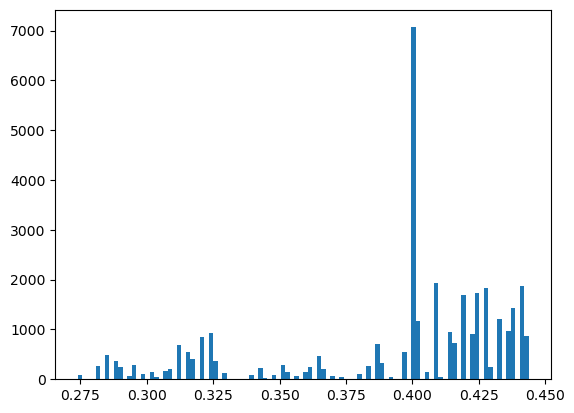

In [265]:
years = np.array([dec_year(dt) for dt in pd.to_datetime(db['created_at'])])

_ = plt.hist(years - 2025, bins=100)

In [273]:
#annotations_json = [json.loads(q) for q in db.annotations]
#print(annotations_json)
#print(db['annotations'])
#print(db['annotations'][1])

gals_data = {}    #all galaxies, classification data ordered by galaxy. Dictionary of list of lists - gal name: [[T0 data], [T1 data], etc]

no_issues = []    #for subjs with no issues, at least one confident classification, no comments.
        #List - gal name
NI_unconf = []    #for subjs with no issues but all classifications were marked as unconfident
        #or at least one had a comment. List of lists - gal name, [comment1,comment2]


for index, row in db.iterrows():
    #print(row)

    #galaxy subject for each classification
    _, gal = row['subject_data'].split(f'"Galaxy":"')
    gal = gal.rstrip(f'"}}')
    #print(gal)
    
    anno = row['annotations']
    anno_json = json.loads(anno)
    
    T7_val = ''
    T0_val = ''
    T2_val = ''
    T3_val = ''
    T5_val = ''
    T6_val = ''
    T4_val = ''
    for i in range(len(anno_json)):    #goes through each task in the classification
        task = anno_json[i]

        
        #these are arranged by the final workflow order
        if task['task'] == 'T7':    #No issues
            T7_val = task['value']
                
        if task['task'] == 'T0':    #Good/Bad
            T0_val = task['value']

        if task['task'] == 'T2':    #Missing Ellipse
            T2_val = task['value']
            
            if str(T2_val) != '[]':
                coords = [T2_val[0]['x'], T2_val[0]['y']]
                T2_val = coords

        if task['task'] == 'T3':    #Oversized Ellipse
            T3_val = task['value']
            
            if str(T3_val) != '[]':
                #T3_dict = json.loads(T3_val[0])
                coords = [T3_val[0]['x'], T3_val[0]['y']]
                T3_val = coords
                
        if task['task'] == 'T5':    #Not Centered Ellipse
            T5_val = task['value']
            
            if str(T5_val) != '[]':
                coords = [T5_val[0]['x'], T5_val[0]['y']]
                T5_val = coords
                
        if task['task'] == 'T6':    #Confidence
            T6_val = task['value']

        if task['task'] == 'T4':    #Comments
            T4_val = task['value']

    task_list = [T7_val, T0_val, str(T2_val), str(T3_val), str(T5_val), T6_val, T4_val]
    #print(task_list)
    #print(task_list)

    if task_list[0] == None:    #problem with 'no issues' task. Described below
        _ = 0
        
    elif task_list == ['', 'Good', '[]', '[]', '[]', 'I am confident.', '']:  #manually adds T7 answer
        task_list[0] = 'Yes'
        
    elif task_list[0] != 'Yes':
        task_list[0] = 'No'

    if task_list[0] != None:    #removes the null classifications
        if gal not in gals_data:
            gals_data[gal] = task_list
        
        elif type(gals_data[gal][i]) == str:
            for i in range(len(task_list)):
                gals_data[gal][i] = [gals_data[gal][i], task_list[i]]

        elif type(gals_data[gal][i]) == list:
            for i in range(len(task_list)):
                gals_data[gal][i].append(task_list[i])



#There's an issue after the 'no issues' task was added where, if the question was skipped (value = null), any data from after
#that point isn't on the export data. Not sure if there's a way to fix this, as is, there's 576 classifications with this issue. For now
#I've made it so those classifications are excluded.
#I'm also not sure why the length of gals_data isn't equal to the number of subjects, since even those null classifications are
#still included.

print(len(gals_data), gals_data)


16329 {'SGA2025_J213.4579+10.5393': [['Yes', 'Yes'], ['Good', 'Good'], ['[]', '[]'], ['[]', '[]'], ['[]', '[]'], ['I am confident.', 'I am confident.'], ['', '']], 'SGA2025_J157.1560+30.2096': [['Yes', 'Yes'], ['Good', ''], ['[]', ''], ['[]', ''], ['[]', ''], ['I am confident.', ''], ['', '']], 'SGA2025_J186.0580+07.9529': [['Yes', 'Yes'], ['Good', ''], ['[]', ''], ['[]', ''], ['[]', ''], ['I am confident.', ''], ['', '']], 'SGA2025_J242.1648+12.0106': [['Yes', 'Yes', 'Yes'], ['Good', 'Good', ''], ['[]', '[]', ''], ['[]', '[]', ''], ['[]', '[]', ''], ['I am confident.', 'I am confident.', ''], ['', '', '']], 'SGA2025_J255.0607+23.1063': [['No', 'Yes'], ['Good', ''], ['[]', ''], ['[190.59254455566406, 369.28314208984375]', ''], ['[]', ''], ['I am confident.', ''], ['', '']], 'SGA2025_J210.7459+09.4712': [['Yes', 'Yes'], ['Good', ''], ['[]', ''], ['[]', ''], ['[]', ''], ['I am confident.', ''], ['', '']], 'SGA2025_J225.3094+43.1445': [['No', 'Yes', 'Yes'], ['Good', 'Good', ''], ['[]', '[